In [18]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import random;
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score,  accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.tree import export_graphviz

In [19]:
# setup random seed consistently across libraries
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [20]:
# load data
df_shifts = pd.read_csv('../data/interim/combined_precleaned.csv')
df_shifts.columns.values

array(['Unnamed: 0', 'id', 'created_at', 'shift_id', 'action',
       'worker_id', 'facility_id', 'lead_time', 'dayOfWeek', 'hourOfDay',
       'shift_day', 'facility_id_shift', 'start_shift', 'agent_req_shift',
       'end_shift', 'deleted_shift', 'shift_type_shift',
       'created_at_shift', 'verified_shift', 'charge_shift', 'time_shift',
       'dayOfWeek_shift', 'hourOfDay_shift', 'day_shift',
       'totalComp_shift', 'short_shift', 'holiday_shift_ind',
       'weather_shift_ind', 'canceled'], dtype=object)

In [21]:
# TODO: some more cleanup in previous notebook (thought I'd done that..):
# both facility_id and facility_id_shift still here
# both dayOfWeek_shift and dayOfWeek still here (dito hour)
# short_shift still here

### Feature selection

In [22]:
# select subset of columns as features: omit those that are merely 'administrative' or redundant
# TODO: consider additional feature derived from end_shift (hourOfDay_shift_end) - together with hourOfDay_shift, may be better indicator for day/eve/night shift than shift_type_shift, similar to time_shift being better than short_shift
numerical_features = ['time_shift', 'charge_shift', 'totalComp_shift']
categorical_features = ['facility_id', 'dayOfWeek_shift', 'hourOfDay_shift', 'agent_req_shift', 'shift_type_shift', 'holiday_shift_ind'] #, 'weather_shift_ind']
label = 'canceled'

df_feat = df_shifts[numerical_features + categorical_features + [label]]
df_feat.head(5)

# DEBUG
# df_feat.drop(columns='facility_id', inplace=True, axis=1)

,time_shift,charge_shift,totalComp_shift,facility_id,dayOfWeek_shift,hourOfDay_shift,agent_req_shift,shift_type_shift,holiday_shift_ind,canceled
0,11.50,32.00000,287.040000,60c0ea658d75cf0166350164,4,22,CNA,noc,False,0
1,11.33,32.00000,282.796800,60c0ea658d75cf0166350164,5,22,CNA,noc,False,0
2,11.50,42.00000,376.740000,6115360adf8ad201660e11c5,4,22,CNA,noc,False,0
3,2.00,41.41852,64.612891,607edf32440b57016171d216,4,11,LVN,custom,False,0
4,8.00,32.00000,199.680000,609975612a95760166932b34,5,18,CNA,pm,False,0


In [23]:
# define label vs. features
y = df_feat.canceled
X = df_feat[df_feat.columns.difference([y.name])]

### Determine the Scaler

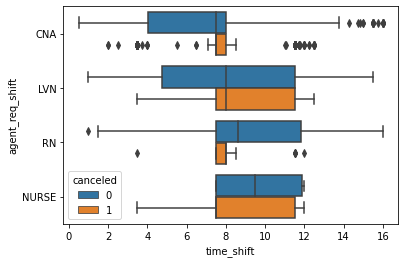

In [24]:
# charge_shift, time_shift, totalComp_shift need to be centered & scaled
sns.boxplot(data=df_feat, x='time_shift', y='agent_req_shift', hue='canceled');

While there are outliers, looking across healthcare worker types none of the very short and very long shift length are inherently implausible. It may be worth investigating whether very short shifts are booked by the same worker adjacent to a longer shift. 

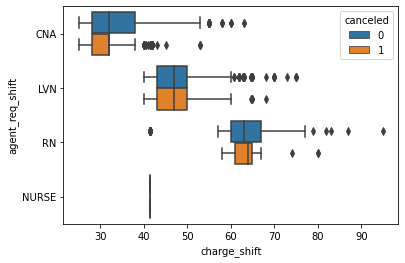

In [25]:
sns.boxplot(data=df_feat, x='charge_shift', y='agent_req_shift', hue='canceled');

Hourly charges for the three main categories of workers all have outliers, but this may have explanations such as special training or to balance short shift length. Latter may be worth investigating.

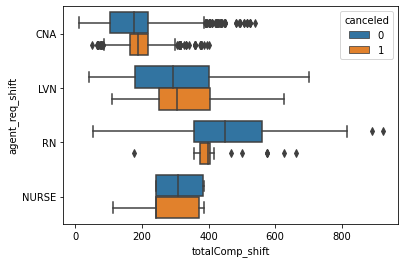

In [26]:
sns.boxplot(data=df_feat, x='totalComp_shift', y='agent_req_shift', hue='canceled');

None of the outliers can be identified as obvious 'mistakes'. However, their presence indicates use of Robust scaling.

### Set up preprocessing: scale and one-hot encode

In [27]:
# define factory method for scaler (note that scaler needs to be derived from training set only, then applied to both train and test data)
def make_scaler():
    return RobustScaler()

In [28]:
# setup a preprocessor to scale numerical features and one-hot encode categorical features(later to be included in pipeline)

# note: facility_id has a large number of categories -> explicitly include so the training set will not miss any (actually best to do that for all categorical variables with high cardinality, e.g., add hourofday, dayofweek)
facility = 'facility_id'
facility_categories = df_feat.facility_id.unique() # DEBUG
hour = 'hourOfDay_shift' 
# one-hot encoder expects numeric categories to be sorted
hour_categories = sorted(df_feat.hourOfDay_shift.unique())
remain_cat_features = [i for i in categorical_features if i not in [facility, hour]]

preprocessor = ColumnTransformer(
    transformers=[
        ('scale_numerical', make_scaler(), numerical_features),
        ('onehot_facility', OneHotEncoder(categories = [facility_categories], drop='first'), [facility]), # DEBUG 
        ('onehot_hour', OneHotEncoder(categories = [hour_categories], drop='first'), [hour]),
        ('onehot_categorical', OneHotEncoder(drop='first'), remain_cat_features)
    ],
    remainder='passthrough'
)

preprocessor_no_scale = ColumnTransformer(
    transformers=[
        ('onehot_facility', OneHotEncoder(categories = [facility_categories], drop='first'), [facility]), # DEBUG 
        ('onehot_hour', OneHotEncoder(categories = [hour_categories], drop='first'), [hour]),
        ('onehot_categorical', OneHotEncoder(drop='first'), remain_cat_features)],
    remainder='passthrough'
)

### Determine the Test / Train Split

In [29]:
# check for class imbalance 
df_feat.canceled.value_counts()

canceled
0    7876
1    1300
Name: count, dtype: int64

In [30]:
# About 1:6 ratio of positive class (canceled) to negative class (booked)
# setup class weights for later use
class_weights = {0: 1, 1: 6}

Imbalanced classes may benefit from stratification (and/or from suffling, since it was sorted according to created_at during munging/EDA). Also, since there are only 1300 positive (canceled) instances of the positive class, pick test_size on the lower end to maximize training data.

In [31]:
# split data into train / test sets: shuffles by default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

For cross validation, set the test_size a bit higher than the default to make sure hyperparameters for model are picked so it generalizes well.

In [32]:
# define factory method for train/test split for cross validation
def make_cv_strategy():
    # default test_size is 0.1
    return StratifiedShuffleSplit(n_splits=5 , test_size=0.15)

### Grid Search and Scoring on Test Data

#### Models for comparison: Random Forest, Decision Tree, Logistic Regression, CatBoost, SVM

In [33]:
def make_rf_classifier(name='classifier'):
    param_grid = {
    name + '__n_estimators': [100, 200, 300],
    name + '__max_depth': [None, 5, 10]
    }
    classifier = RandomForestClassifier(class_weight='balanced')
    return (classifier, param_grid)

In [34]:
def make_tree_classifier(name='classifier', max_depth=8):
    param_grid = {
    name + '__criterion': ['gini'], # ['gini', 'entropy']
    name + '__max_depth': [i for i in range(3,max_depth)],
    # name + '__min_samples_split': [25, 50, 100],
    # name + '__min_samples_leaf': [50, 75, 100, 150, 250, 500],
    # there are just over 100 featuers, given the cardinality of the categorical features (incl. 60 facilities)
    name + '__max_features': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
    name + '__max_leaf_nodes': [6, 9, 12, 15]
    # name + '__min_impurity_decrease': [0.004, 0.005, 0.006, 0.007]
    }
    classifier = DecisionTreeClassifier(class_weight='balanced') # probability=True not supported in tree model
    return (classifier, param_grid)

In [35]:
# TODO: parameterize to run with other penalty/solver combos 
def make_logreg_classifier(name='classifier'):
    param_grid = {
    name + '__penalty': ['l2', 'none'], # ['l1', 'l2', 'elasticnet', 'none'],
    name + '__C': [0.001, 0.01, 0.1, 1.0],
    # newton-cg only with penalty l2 or none 
    name + '__solver': ['newton-cg'], # 'lbfgs', 'sag', 'saga', 'liblinear'
    name + '__max_iter': [100, 150, 200],
    # name + '__class_weight': [None, 'balanced'],
    # name + '__multi_class': ['auto', 'ovr', 'multinomial'],
    # name + '__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
    }
    classifier = LogisticRegression(class_weight='balanced')
    return (classifier, param_grid)

In [36]:
# TODO: more params...
def make_catboost_classifier(name='classifier'):
    param_grid = {
    name + '__iterations': [100, 200, 300],
    name + '__learning_rate': [0.01, 0.05, 0.1],
    name + '__depth': [4, 6, 8],
    name + '__l2_leaf_reg': [1, 3, 5],
    }
    classifer = CatBoostClassifier(class_weights=class_weights, verbose=False)
    return (classifer, param_grid)

In [37]:
def make_catboost_native_classifier(name='classifier'):
    param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    }
    # cat_features_indices = [df_feat.columns.get_loc(col) for col in # categorical_features]
    # print(cat_features_indices)
    # print(np.asarray(cat_features_indices))
    classifer = CatBoostClassifier(class_weights=class_weights, verbose=False, cat_features= categorical_features)# np.asarray(cat_features_indices))
    return (classifer, param_grid)

In [38]:
# TODO: more params...
def make_gradboost_classifier(name='classifer'):
    param_grid = {
    name + '__n_estimators': [100, 200, 300],
    name + '__learning_rate': [0.01, 0.05, 0.1],
    name + '__max_depth': [3, 4, 5],
    name + '__min_samples_split': [2, 5, 10],
    }
    classifer = GradientBoostingClassifier(class_weight='balanced')
    return (classifer, param_grid)

In [39]:
# TODO: more params
def make_SVM_classifier(name='classifer'):
    param_grid = {
    name + '__C': [0.1, 1], # [0.01, 0.1, 1, 10]
    name + '__kernel': ['linear', 'poly'], # ['linear', 'poly', 'rbf']
    name + '__gamma': ['auto'], # ['scale', 'auto'],
    }
    classifier = SVC(class_weight='balanced', probability=True)
    return (classifier, param_grid)

In [40]:
# could try this for logreg
# problem: fixed threshold leads to nan scores
def logreg_f1(y_true, y_pred):
    print('.')
    threshold = 0.45
    y_pred_fixed = (y_pred[:, 1] >= threshold).astype(int)
    return f1_score(y_true, y_pred_fixed)

# makes small difference (also: not sure about + vs. -, correct identification of positive class)
def logreg_f1_dyn_threshold(y_true, y_probabilities):
    threshold_percentage = 0.5  # Adjust this value as needed
    
    # temp code to see if custom scorer is used
    # display(f"Threshold: {threshold_percentage}")

    # Adjust the threshold based on the current fold's predictions
    threshold = np.mean(y_probabilities) + threshold_percentage * np.std(y_probabilities)

    # Calculate the binary predictions based on the adjusted threshold
    y_pred = (y_probabilities >= threshold).astype(int)

    # Calculate the F1-score with the adjusted threshold
    return f1_score(y_true, y_pred)

# problem: leads to f1 nan, possibly because some folds have no true positives
def logreg_f1_class_weights_auto(y_true, y_pred):
    return f1_score(y_true, y_pred, average='binary', pos_label=1, sample_weight='balanced')

# significantly improves f1 score - however, weighted scoring should not be 
# used in conjunction with weighted model
def logreg_f1_class_weights_fix(y_true, y_pred):
    return f1_score(y_true, y_pred, average='binary', pos_label=1, sample_weight=[class_weights[label] for label in y_true])


#### Grid Search

In [41]:
# setup a dataframe to collect scores during fit() and model_eval()
train_score = 'train_rocauc'
df_model_stats = pd.DataFrame(columns=['model', train_score, 'test_rocauc', 'test_accuracy', 'test_f1'])
model_stats_train = []
model_stats_test = []

In [42]:
def fit(gs_cv, model_name):
    gs_cv.fit(X_train,y_train)
    print("Best Train Score:" + str(gs_cv.best_score_))
    print("Method:", gs_cv.scoring)
    print("Best Train Parameters: " + str(gs_cv.best_params_))
    model_stats_train.append({'model': model_name, train_score: gs_cv.best_score_ })
    #df_model_stats = pd.concat([df_model_stats, pd.Series({'model': model_name, train_score: gs_cv.best_score_ }).to_frame().T], ignore_index=True)

In [43]:
def gridsearch(model_name, classifier, scorer=make_scorer(roc_auc_score,needs_proba=True)):
    # old: scorer=make_scorer(f1_score, pos_label=1)
    # new: # scorer=make_scorer(roc_auc_score,needs_proba=True)
    # note: needs_proba not needed for LogisticRegression (provides it by default), but for tree based models? <- TODO: double check
    
    pipe = Pipeline([ ('preprocessor', preprocessor), (model_name, classifier[0])])
    gs_cv = GridSearchCV(pipe, classifier[1], cv=make_cv_strategy(), scoring=scorer) # 'f1' 'accuracy'
    fit(gs_cv, model_name)
    return gs_cv

In [44]:
def gridsearch_catboost_native(model_name, classifier, scorer=make_scorer(roc_auc_score,needs_proba=True)):
    #pipe = Pipeline((model_name, classifier[0]))
    gs_cv = GridSearchCV(classifier[0], classifier[1], cv=make_cv_strategy(), scoring=scorer)
    fit(gs_cv, model_name)
    return gs_cv


In [45]:
def gridsearch_tree(model_name, classifier, scorer=make_scorer(roc_auc_score,needs_proba=True)):
    pipe = Pipeline([ ('preprocessor', preprocessor_no_scale), (model_name, classifier[0])])
    gs_cv = GridSearchCV(pipe, classifier[1], cv=make_cv_strategy(), scoring=scorer) # 'f1' 'accuracy'
    fit(gs_cv, model_name)
    return gs_cv

#### Scoring on Test Data

In [46]:
def roc(model):
   # best_estimator = gs_cv.best_estimator_

    # Predict probabilities for the positive class (class 1)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate the Area Under the ROC Curve (AUC)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [47]:
def model_eval(gs_cv, model_name):
    model = gs_cv.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
     # FIX: model.predict returns 0 or 1 label for target class
    # need to use predict_proba for roc_auc score to be corret
    y_prob = model.predict_proba(X_test)[:, 1]
    roc_auc =  roc_auc_score(y_test, y_prob)
    print("Test Accuracy Score:", accuracy)
    print("Test ROC-AUC Score:", roc_auc)
    print("Test F1 Score:", f1)
    #df_model_stats.append({'model': model_name, 'test_rocauc': roc_auc, 'test_accuracy': accuracy, 'test_f1': f1}, ignore_index=True)
    #f_model_stats = pd.concat([df_model_stats, pd.Series({'model': model_name, 'test_rocauc': roc_auc, 'test_accuracy': accuracy, 'test_f1': f1}).to_frame().T], ignore_index=True)
    model_stats_test.append({'model': model_name, 'test_rocauc': roc_auc, 'test_accuracy': accuracy, 'test_f1': f1})
    roc(model)

ROC curve

#### Feature Importance

In [48]:
def feature_importance(gs_cv, model_name='classifier'):
    best_pipeline = gs_cv.best_estimator_
    column_transformer = best_pipeline.named_steps['preprocessor']
    feature_names = column_transformer.get_feature_names_out()
    model = gs_cv.best_estimator_.named_steps[model_name]
    # for LinearRegressionClassifier, need to use coef_ instead to get weights
    importances = []
    sign = []
    if isinstance(model, LogisticRegression):
        importances = model.coef_.ravel()
         # coef can be negative
        sign = np.sign(importances)
        importances  = np.abs(importances) 
    else:
        importances = list(model.feature_importances_)
        sign = [0] * len(importances)
    # doesn't work - feature importance always positive, see
    # https://catboost.ai/en/docs/concepts/fstr#regular-feature-importance
    '''
    elif isinstance(model, CatBoostClassifier):
        importances = model.get_feature_importance(type="PredictionValuesChange")
        print(importances)
        sign = np.sign(importances)
        importances  = np.abs(importances) 
    '''

    df_feat_importance = pd.DataFrame(list(zip(feature_names, importances, sign)),columns =['feature', 'importance_score', 'sign']) 
    df_feat_importance.sort_values(by='importance_score', inplace=True, ascending=False)
    #print(df_feat_importance.head(15))
    custom_palette = {1: "blue", 0: "lightblue", -1: "orange"}
    sns.barplot(data=df_feat_importance.head(15), y='feature', x='importance_score', orient='h', hue='sign', palette=custom_palette)
    

#### Running the Models

##### Decision Tree

In [49]:
# grid search w. cross validation
tree  = make_tree_classifier('tree')
# DecisionTree doesn't support predic_proba(), it only predicts lables -> 
# pass in f1 scorer to overwrite default roc_auc scorer
# scorer=make_scorer(f1_score, pos_label=1)
tree_gs_cv  = gridsearch('tree', tree)

Best Train Score:0.7438773572106906
Method: make_scorer(roc_auc_score, needs_proba=True)
Best Train Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 7, 'tree__max_features': 0.9, 'tree__max_leaf_nodes': 15}


Test Accuracy Score: 0.5501089324618736
Test ROC-AUC Score: 0.7487224228816869
Test F1 Score: 0.36363636363636365


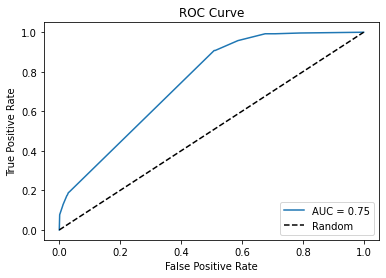

In [50]:
model_eval(tree_gs_cv, 'tree')

Decision Tree Top Features

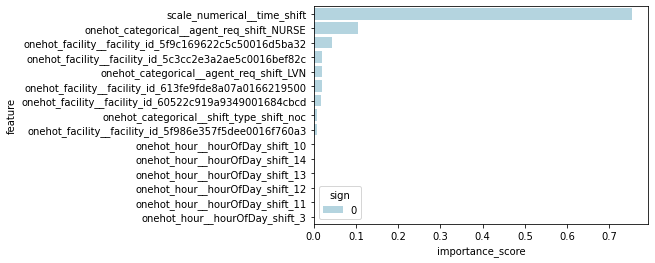

In [51]:
feature_importance(tree_gs_cv, 'tree')

Visualize the Decision Tree

In [52]:
# retrieve the feature names generated by the column transformer (input to model)
# note: name is used both to retrieve model from pipeline AND file names
def tree_viz(tree_gs_cv, name='tree'):
    best_pipeline = tree_gs_cv.best_estimator_
    column_transformer = best_pipeline.named_steps['preprocessor']
    feature_names = column_transformer.get_feature_names_out()

# generate a tree representation into file
    model = tree_gs_cv.best_estimator_.named_steps.get(name)
    class_dict = {0:'booked', 1:'canceled'}
    export_graphviz(model, out_file= name +'.dot', 
                feature_names = feature_names,
                 # note on order: checked that it's same as unique()
                class_names = [class_dict.get(i) for i in model.classes_],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# convert it to image
    from subprocess import call
    call(['dot', '-Tpng', name + '.dot', '-o', name + '.png', '-Gdpi=150'])

# display in notebook
    from IPython.display import Image
    return Image(filename = name + '.png')

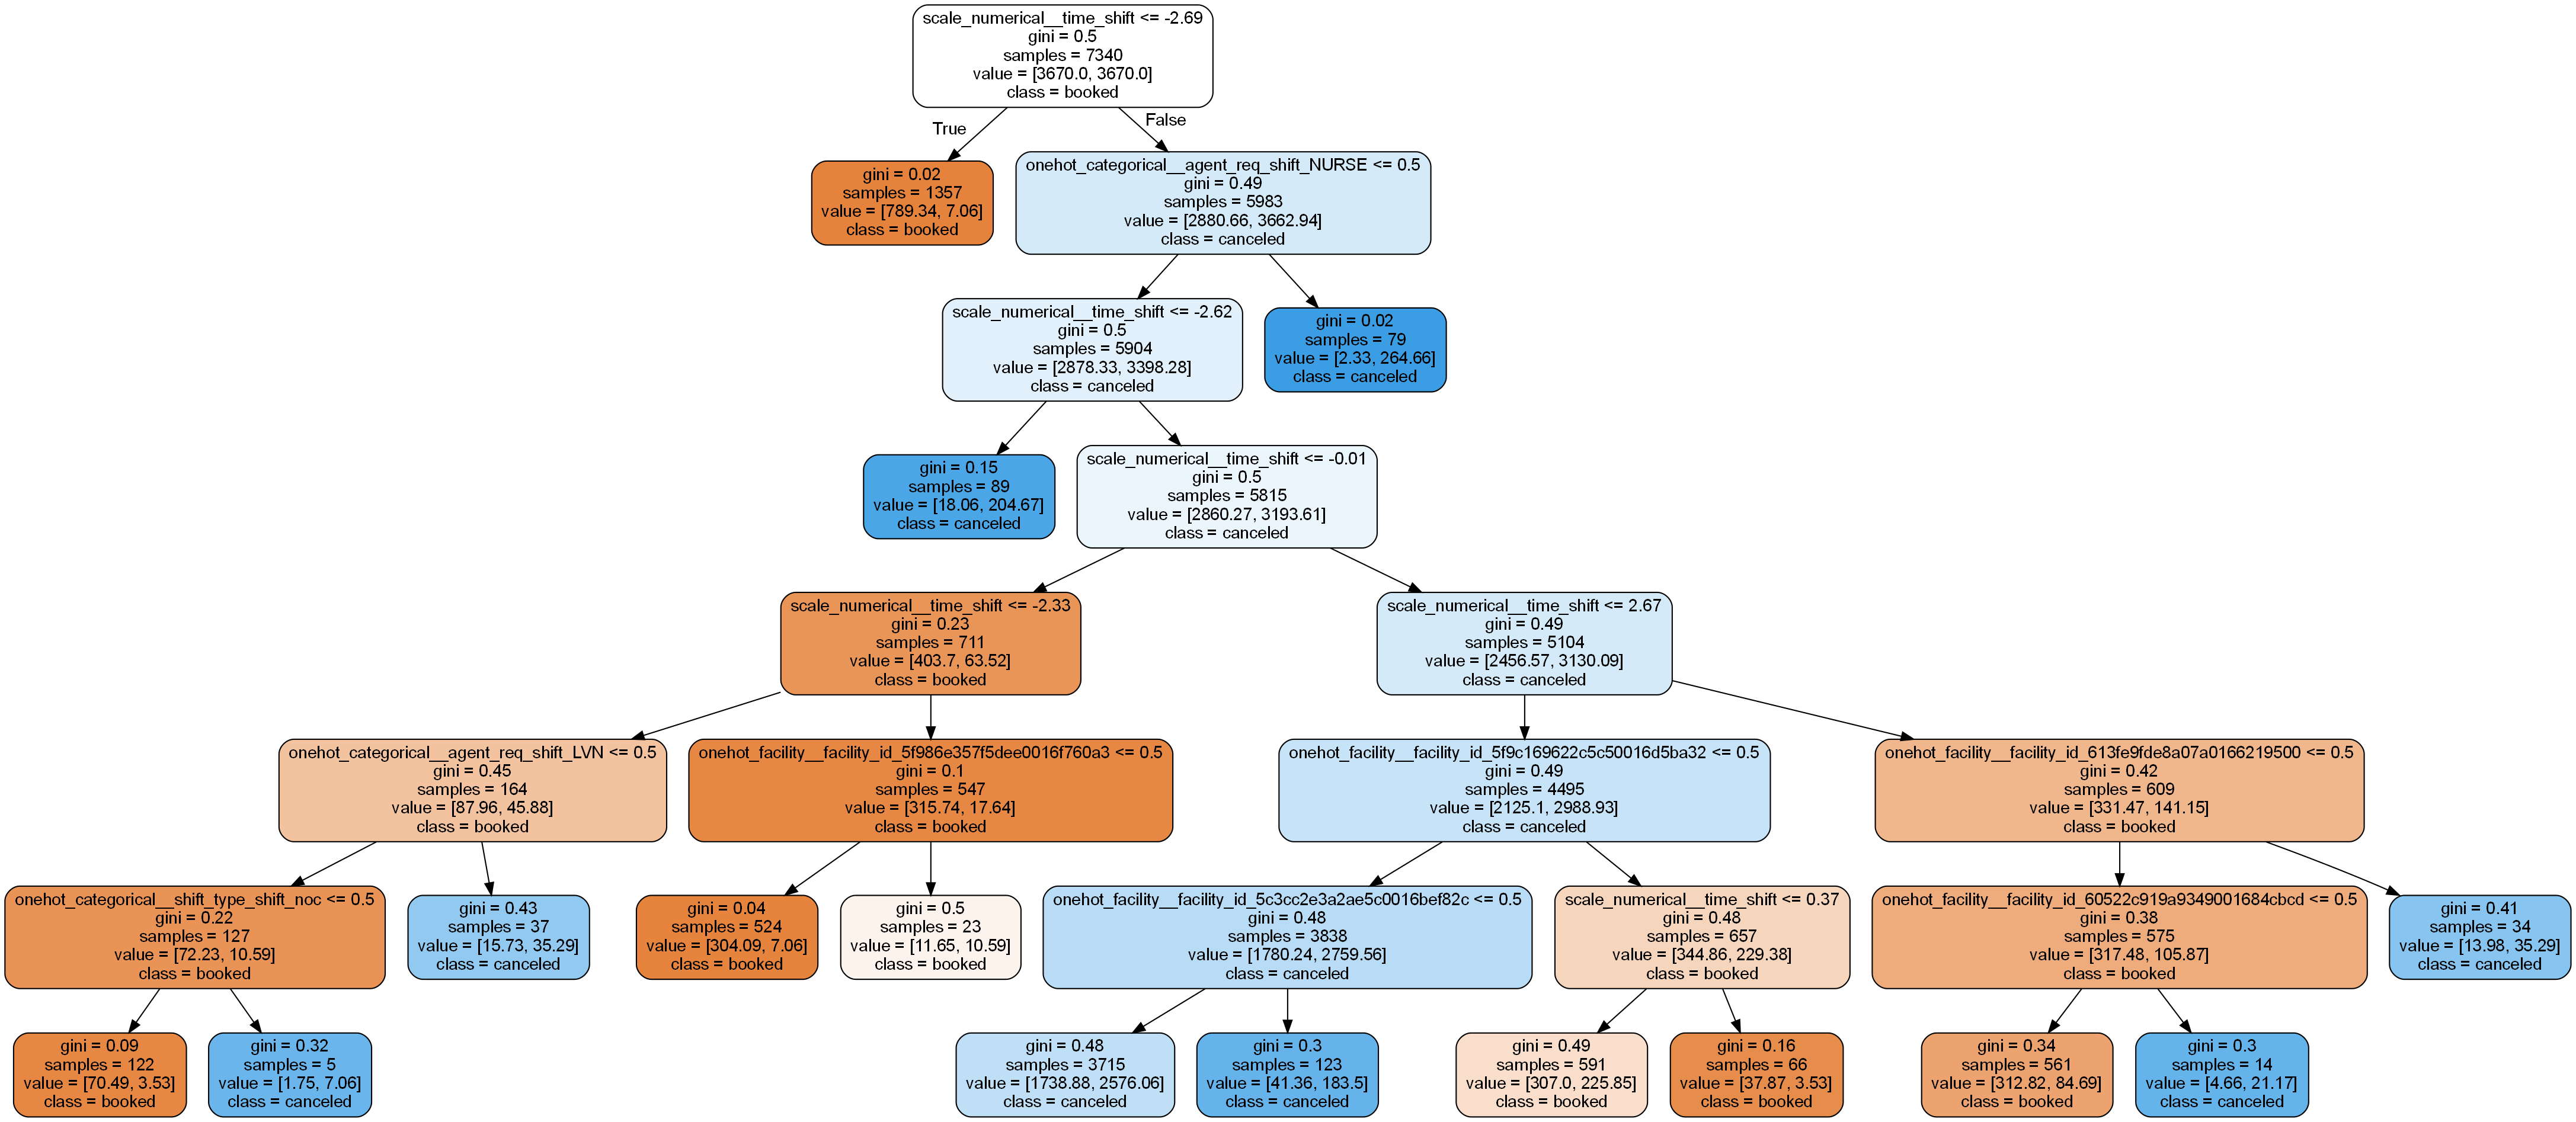

In [53]:
tree_viz(tree_gs_cv, 'tree')

Problems:
* remaining impurities seem high
* scaled features lead to loss of interpretability

##### Decision Tree without pre-processing

In [54]:
tree_unscaled = make_tree_classifier('tree_noscale')
tree_unscaled_gs_cv  = gridsearch_tree('tree_noscale', tree_unscaled)

Best Train Score:0.7446486229819563
Method: make_scorer(roc_auc_score, needs_proba=True)
Best Train Parameters: {'tree_noscale__criterion': 'gini', 'tree_noscale__max_depth': 7, 'tree_noscale__max_features': 0.85, 'tree_noscale__max_leaf_nodes': 15}


Test Accuracy Score: 0.5898692810457516
Test ROC-AUC Score: 0.7470702362358455
Test F1 Score: 0.3698744769874477


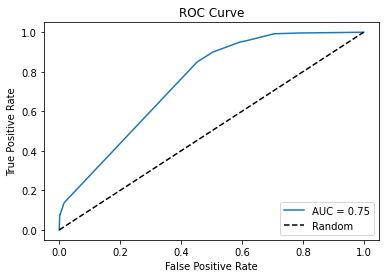

In [55]:
model_eval(tree_unscaled_gs_cv, 'tree_noscale')

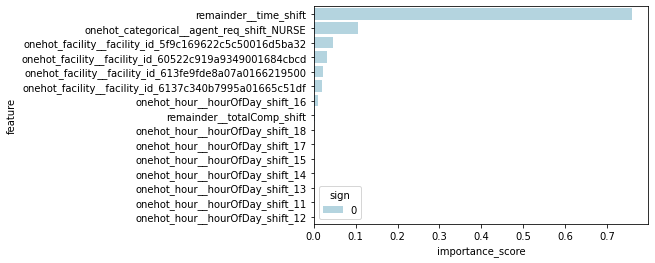

In [56]:
feature_importance(tree_unscaled_gs_cv, 'tree_noscale')

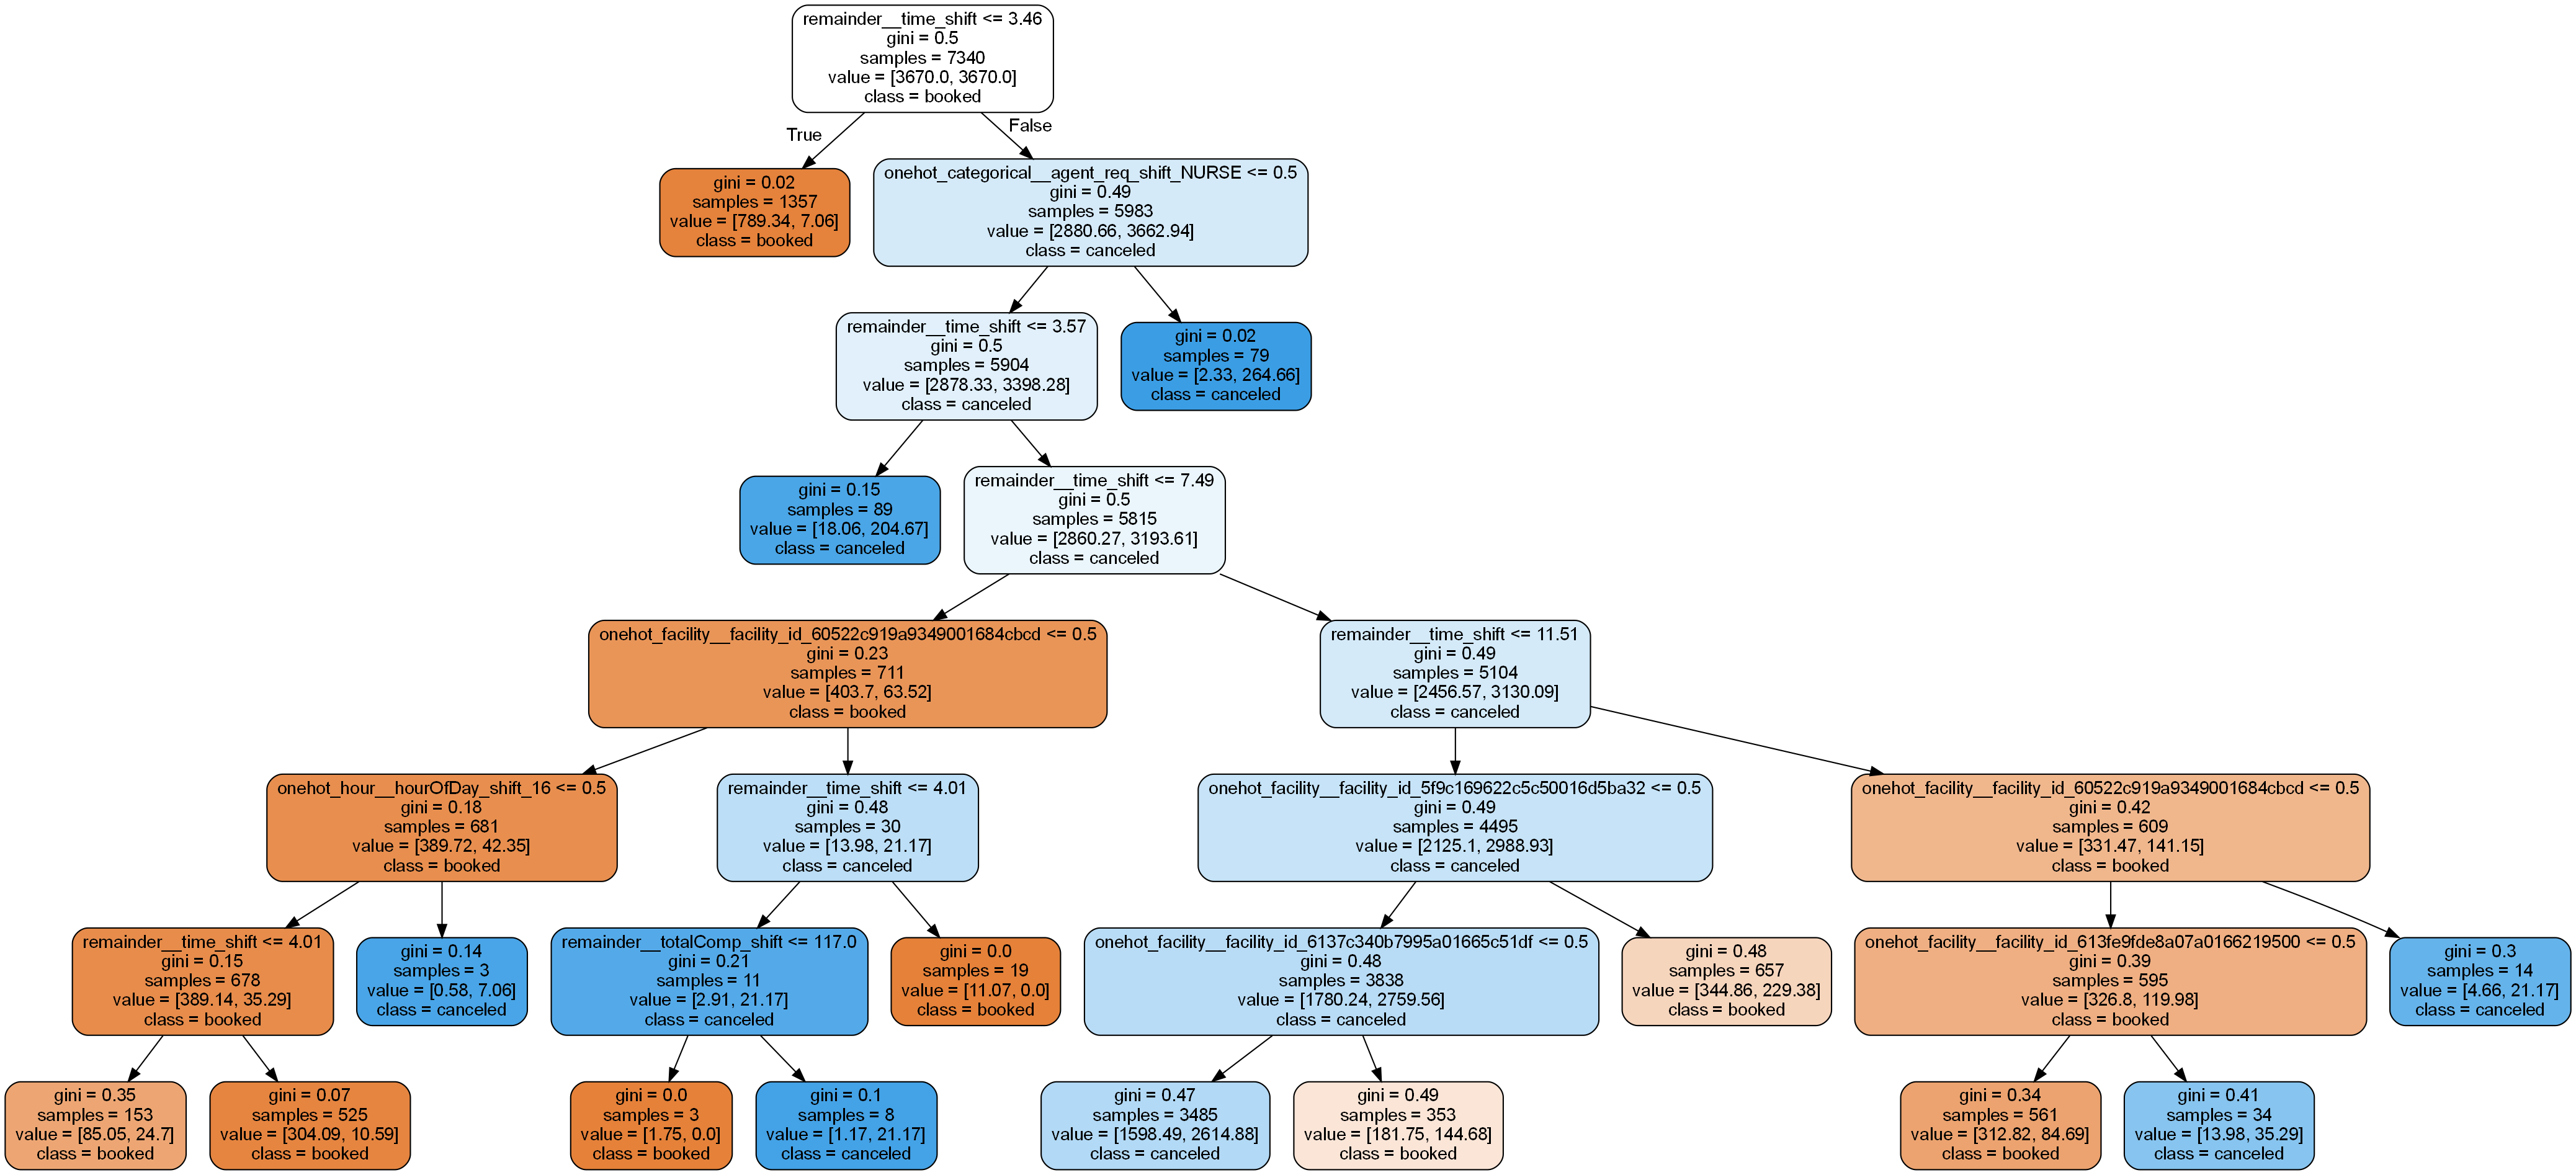

In [57]:
tree_viz(tree_unscaled_gs_cv, name='tree_noscale')

##### Stumpy Decision Tree

In [58]:
tree_small = make_tree_classifier('tree_small', max_depth=4)
tree_small_gs_cv  = gridsearch_tree('tree_small', tree_small)

Best Train Score:0.6568043684710352
Method: make_scorer(roc_auc_score, needs_proba=True)
Best Train Parameters: {'tree_small__criterion': 'gini', 'tree_small__max_depth': 3, 'tree_small__max_features': 0.75, 'tree_small__max_leaf_nodes': 6}


Test Accuracy Score: 0.3202614379084967
Test ROC-AUC Score: 0.6458182838734869
Test F1 Score: 0.2933182332955832


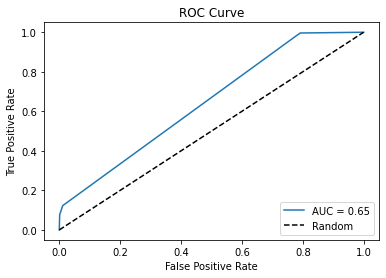

In [59]:
model_eval(tree_small_gs_cv, 'tree_small')

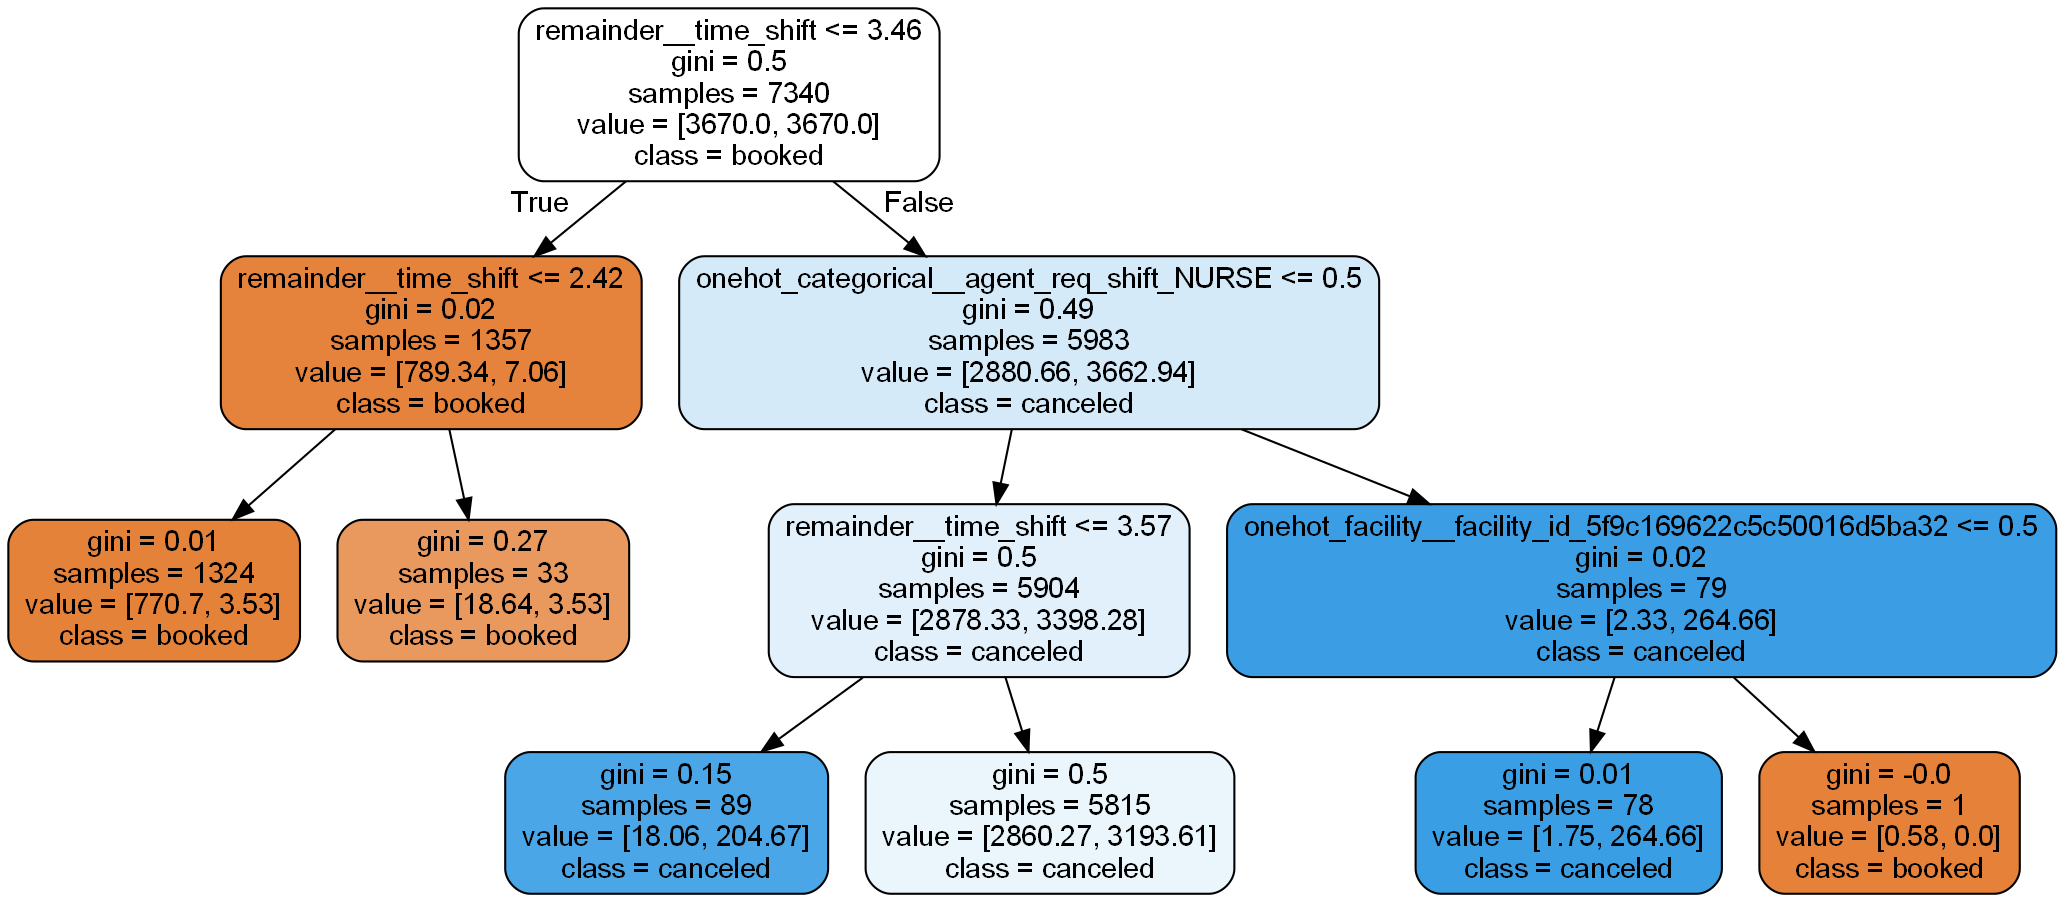

In [60]:
tree_viz(tree_small_gs_cv, name='tree_small')

##### Random Forest

In [61]:
# Random Forest grid search w. cross validation
forest  = make_rf_classifier('forest')
forest_gs_cv = gridsearch('forest', forest)

Best Train Score:0.7884846018179351
Method: make_scorer(roc_auc_score, needs_proba=True)
Best Train Parameters: {'forest__max_depth': 10, 'forest__n_estimators': 200}


Test Accuracy Score: 0.6721132897603486
Test ROC-AUC Score: 0.8002464857477548
Test F1 Score: 0.4109589041095891


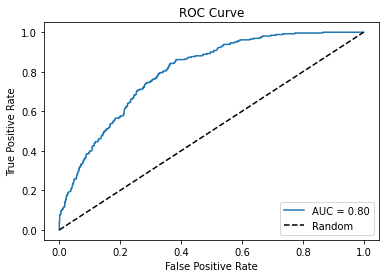

In [62]:
model_eval(forest_gs_cv, 'forest')

Random Forest Top Features

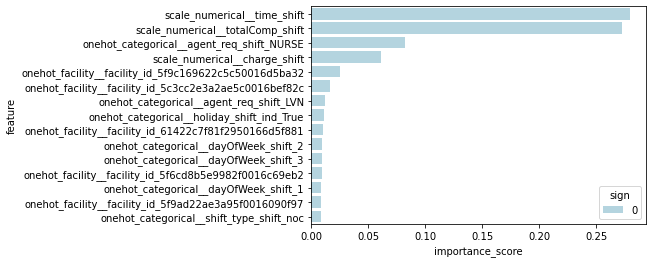

In [63]:
feature_importance(forest_gs_cv, 'forest')

##### Logistic Regression

In [64]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
logreg = make_logreg_classifier('logreg')
# Create the scorer using the custom scoring function
# custom_scorer = make_scorer(logreg_f1_dyn_threshold, needs_proba=True) # pos_label=1)
# custom_scorer = make_scorer(logreg_f1_class_weights_fix) # result: 0.64
logreg_gs_cv = gridsearch('logreg', logreg) # , scorer=custom_scorer

Best Train Score:0.6974799891466559
Method: make_scorer(roc_auc_score, needs_proba=True)
Best Train Parameters: {'logreg__C': 1.0, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}


Test Accuracy Score: 0.6552287581699346
Test ROC-AUC Score: 0.7165560327996876
Test F1 Score: 0.34674922600619196


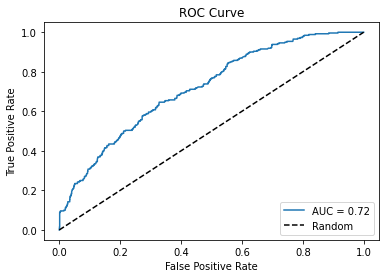

In [65]:
model_eval(logreg_gs_cv, 'logreg')

There seems to be an elbow at around TPR of 0.7 and FPR of 0.3.

TODO: is it possible to derive a better threshold than 0.5 from this?

Logistic Regression Top Features

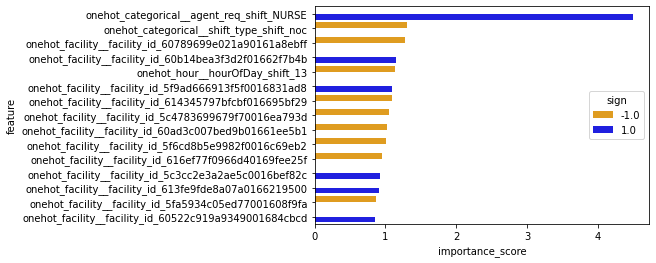

In [66]:
feature_importance(logreg_gs_cv, 'logreg')

Interesting: Only model that does not use time_shift as one of the top features.

##### Gradient Boost (CatBoost)

In [67]:
catboost = make_catboost_classifier('catboost')
catboost_gs_cv = gridsearch('catboost', catboost)

Best Train Score:0.8413227513227515
Method: make_scorer(roc_auc_score, needs_proba=True)
Best Train Parameters: {'catboost__depth': 4, 'catboost__iterations': 300, 'catboost__l2_leaf_reg': 5, 'catboost__learning_rate': 0.1}


Test Accuracy Score: 0.7314814814814815
Test ROC-AUC Score: 0.8408849082389691
Test F1 Score: 0.46120218579234973


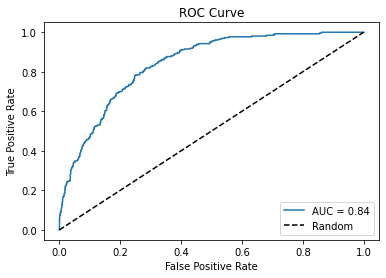

In [68]:
model_eval(catboost_gs_cv, 'catboost')

CatBoost Top Features

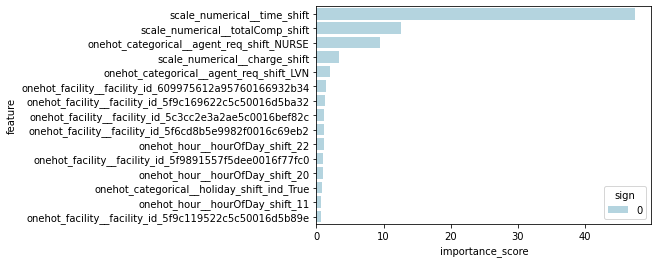

In [69]:
feature_importance(catboost_gs_cv, 'catboost')

##### CatBoost "native"

In [70]:
catboost_native = make_catboost_native_classifier(name='catboost_native')
catboost_native_gs_cv = gridsearch_catboost_native('catboost_native', catboost_native)

Best Train Score:0.8471842355175688
Method: make_scorer(roc_auc_score, needs_proba=True)
Best Train Parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


Test Accuracy Score: 0.7309368191721133
Test ROC-AUC Score: 0.8559400624755956
Test F1 Score: 0.4766949152542373


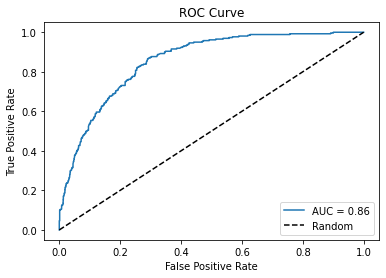

In [71]:
model_eval(catboost_native_gs_cv, 'catboost_native')

"Native" CatBoost pre-processing does not lead to a model with better train scores, generalizes less well, and takes almost an hour compared to 12 minutes.

In [72]:
#feature_importance(catboost_native_gs_cv, 'catboost_native')

##### SVM (leave out for now: takes long time, mentor says 'out of fashion')

In [73]:
'''
model_name = 'classifier'
classifier = make_SVM_classifier(model_name)
gs_cv = gridsearch(model_name, classifier)
model_eval(gs_cv)
'''

"\nmodel_name = 'classifier'\nclassifier = make_SVM_classifier(model_name)\ngs_cv = gridsearch(model_name, classifier)\nmodel_eval(gs_cv)\n"

##### Compare Models

In [74]:
df_train = pd.concat([df_model_stats] + [pd.Series(i).to_frame().T for i in model_stats_train], ignore_index=True)
df_test = pd.concat([df_model_stats] + [pd.Series(i).to_frame().T for i in model_stats_test], ignore_index=True)
df_train.combine_first(df_test).head(10)

,model,train_rocauc,test_rocauc,test_accuracy,test_f1
0,tree,0.743877,0.748722,0.550109,0.363636
1,tree_noscale,0.744649,0.74707,0.589869,0.369874
2,tree_small,0.656804,0.645818,0.320261,0.293318
3,forest,0.788485,0.800246,0.672113,0.410959
4,logreg,0.69748,0.716556,0.655229,0.346749
5,catboost,0.841323,0.840885,0.731481,0.461202
6,catboost_native,0.847184,0.85594,0.730937,0.476695


In [ ]:
# write to file
df_train.to_csv('../complete_model_metrics.csv')

Mentor meeting notes:
* focus on CatBoost, Tree, Logreg 
    - try CatBoost without feature scaling/encoding (better perf?) (done - worse...)
    - try Tree w/o scaling (better interpretability) (done - slightly better scores)
    - try limiting Tree depth (done - scores stank; also (depending on other hyperparams): totalComp at top)
    - do ROC & apply threshold for Logreg after training (usecase: 'give me top 20' most likely to be canceled shifts this week -> ranked measure, check google doc)
* use ROC_AUC (easier to interpret) instead of F1 (done)
* for future: instead of handing categories to OneHotEncoder, use handle_unknown='ignore'
* for future: start with tree ensemble method
* for future: try using worker_id to use a particular worker only in test OR training data set (see 'group k-fold' here: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data)
* would use custom scorer only to factor '$ cost' associated with classification

My own todo list:
* extract & plot feature importance from best_estimator_ (done)
* explain fractions and samples vs. values for tree models
* make table for scores of all models (done)
* feature eng: how to build in thresholds apparent from tree model (~3.5, ~7.5) into features so that it is also visible in CatBoost


In [75]:
# example how to use GroupShuffleSplit to group according to employee id
# advantage: makes sure i.i.d., "independent and identically distributed." assumption is fulfilled
# disadvantage: doesn't stratify

from sklearn.model_selection import GroupShuffleSplit

# Create the GroupShuffleSplit object with the number of splits (n_splits) you want
group_shuffle_split = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Create the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object using GroupShuffleSplit as the cross-validator
grid_search = GridSearchCV(rf_classifier, param_grid, scoring='roc_auc', cv=group_shuffle_split)

# Extract the grouping information (assumed here that it's in first col) from the DataFrame as the groups array - adjust to make it employee id
groups = df_shifts.iloc[:, 0].values

# Fit the grid search on the training data
grid_search.fit(X, y, groups=groups)

# Get the best hyperparameters and corresponding ROC AUC score
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Test the model on the test set with the best hyperparameters
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

ValueError: 
All the 405 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "c:\prg\mincon\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\prg\mincon\lib\site-packages\sklearn\ensemble\_forest.py", line 331, in fit
    X, y = self._validate_data(
  File "c:\prg\mincon\lib\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\prg\mincon\lib\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "c:\prg\mincon\lib\site-packages\sklearn\utils\validation.py", line 791, in check_array
    array = array.astype(new_dtype)
  File "c:\prg\mincon\lib\site-packages\pandas\core\generic.py", line 6324, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "c:\prg\mincon\lib\site-packages\pandas\core\internals\managers.py", line 451, in astype
    return self.apply(
  File "c:\prg\mincon\lib\site-packages\pandas\core\internals\managers.py", line 352, in apply
    applied = getattr(b, f)(**kwargs)
  File "c:\prg\mincon\lib\site-packages\pandas\core\internals\blocks.py", line 511, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "c:\prg\mincon\lib\site-packages\pandas\core\dtypes\astype.py", line 242, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "c:\prg\mincon\lib\site-packages\pandas\core\dtypes\astype.py", line 187, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
  File "c:\prg\mincon\lib\site-packages\pandas\core\dtypes\astype.py", line 138, in _astype_nansafe
    return arr.astype(dtype, copy=True)
ValueError: could not convert string to float: 'CNA'
